# Decoding fMRI using nltools
*written by Luke Chang 8/15/2017*

This tutorial will provide an introduction to the [nltools toolbox](https://github.com/ljchang/nltools), which is loosely based off of Tor Wager's [Matlab Toolbox](https://github.com/canlab/CanlabCore) and is the analysis engine that power [neuro-learn.org](http://neuro-learn.org/).

In addition, we will try to replicate training the Picture Induced Negative Emotion Signature using rating data stored in [neurovault](http://neurovault.org/collections/1964/).  For details about the methods see our [paper](http://cosanlab.com/static/papers/Changetal2015PLoSBiology.pdf).

# Download affective rating dataset from neurovault

Here we fetch the affective rating dataset used in [Chang et al., 2015](http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002180>)
from [neurovault](http://neurovault.org/collections/504/>). In this dataset 
there are 182 subjects with approximately 5 separate beta images reflecting varying intensities
of their negative affective ratings in response to arousing IAPS images. The data will be downloaded to ~/nilearn_data,
and automatically loaded as a Brain_Data() instance.  The image metadata will be stored in data.X.



In [1]:
%matplotlib inline
from nltools.datasets import fetch_emotion_ratings

data = fetch_emotion_ratings()

 
# Basic Data Operations

The bulk of the nltools toolbox is built around the
Brain_Data() class.  This class represents imaging data as a vectorized
features by observations matrix.  Each image is an observation and each voxel
is a feature.  The concept behind the class is to have a similar feel to a pandas
dataframe, which means that it should feel intuitive to manipulate the data.




Basic Brain_Data() Operations
---------------------------------------------------------

Here are a few quick basic data operations.
Find number of images in Brain_Data() instance



In [4]:
print(len(data))

822


Find the dimensions of the data.  images x voxels



In [5]:
print(data.shape())

(822, 238955)


We can use any type of indexing to slice the data such as integers, lists
of integers, or boolean.



In [6]:
print(data[[1,6,2]])

nltools.data.Brain_Data(data=(3, 238955), Y=0, X=(3, 44), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])


Calculate the mean for every voxel over images



In [7]:
data.mean()

nltools.data.Brain_Data(data=(238955,), Y=0, X=(822, 44), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Calculate the standard deviation for every voxel over images



In [8]:
data.std()

nltools.data.Brain_Data(data=(238955,), Y=0, X=(822, 44), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

Methods can be chained.  Here we get the shape of the mean.



In [9]:
print(data.mean().shape())

(238955,)


Brain_Data instances can be added and subtracted



In [10]:
new = data[1]+data[2]

Brain_Data instances can be manipulated with basic arithmetic operations
Here we add 10 to every voxel and scale by 2



In [11]:
data2 = (data+10)*2

Brain_Data instances can be copied 



In [12]:
new = data.copy()

Brain_Data instances can be easily converted to nibabel instances, which 
store the data in a 3D/4D matrix.  This is useful for interfacing with other
python toolboxes such as [nilearn](http://nilearn.github.io/>)



In [13]:
data.to_nifti()

Brain_Data instances can be concatenated using the append method



In [14]:
new = new.append(data[4])

Any Brain_Data object can be written out to a nifti file



In [16]:
data[1].write('Tmp_Data.nii.gz')

Images within a Brain_Data() instance are iterable.  Here we use a list
comprehension to calculate the overall mean across all voxels within an
image.

For speed we only calculate the mean for the first 10 images.

In [17]:
[x.mean() for x in data[:10]]

[0.26385647,
 0.45041031,
 0.42635551,
 0.19531077,
 0.58192825,
 0.14651087,
 0.44709185,
 0.60360801,
 0.28620967,
 0.0038729438]

Basic Brain_Data() Plotting
---------------------------------------------------------

There are multiple ways to plot data.  First, Brain_Data() instances can be 
converted to a nibabel instance and plotted using any plot method such as
nilearn.



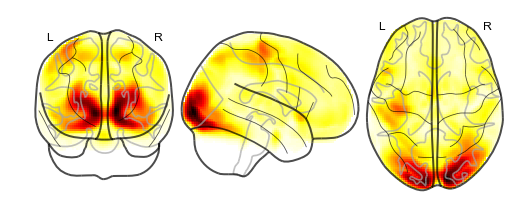

In [18]:
from nilearn.plotting import plot_glass_brain

plot_glass_brain(data.mean().to_nifti())

There is also a fast montage plotting method.  Here we plot the average image
it will render a separate plot for each image.  There is a 'limit' flag
which allows you to specify the maximum number of images to display.



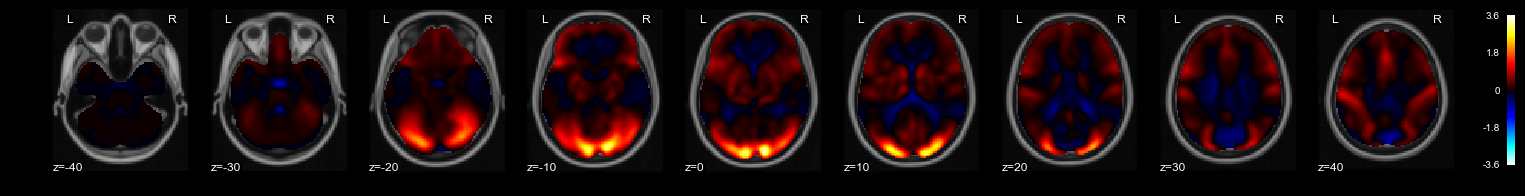

In [19]:
data.mean().plot()

We also have functions to create a more comprehensive plot from multiple orientations

Plotting unthresholded image


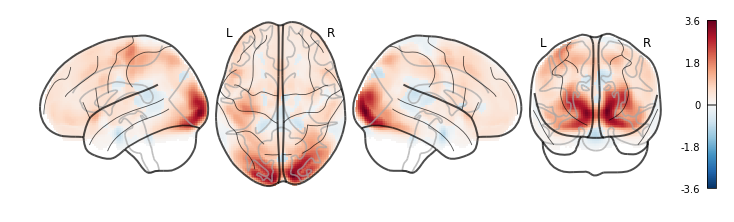

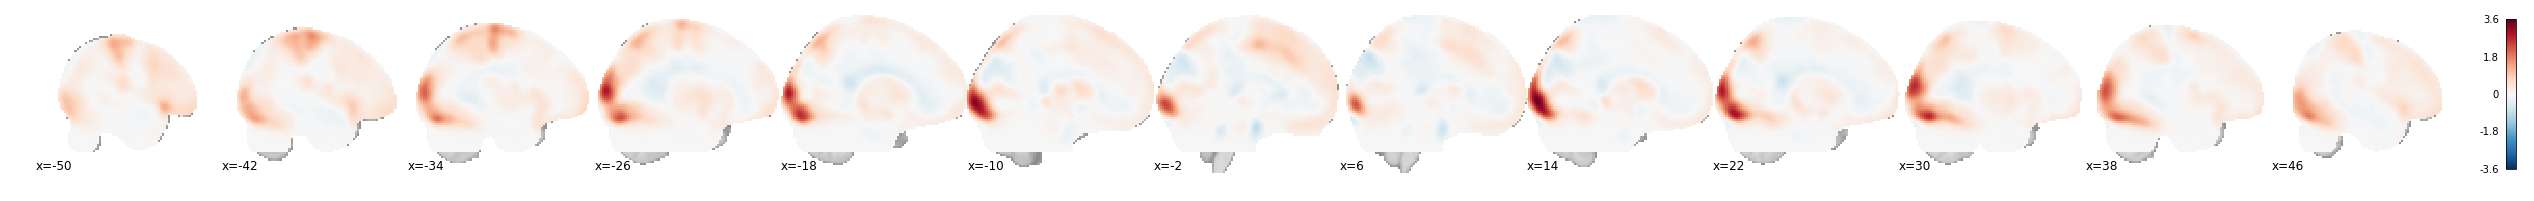

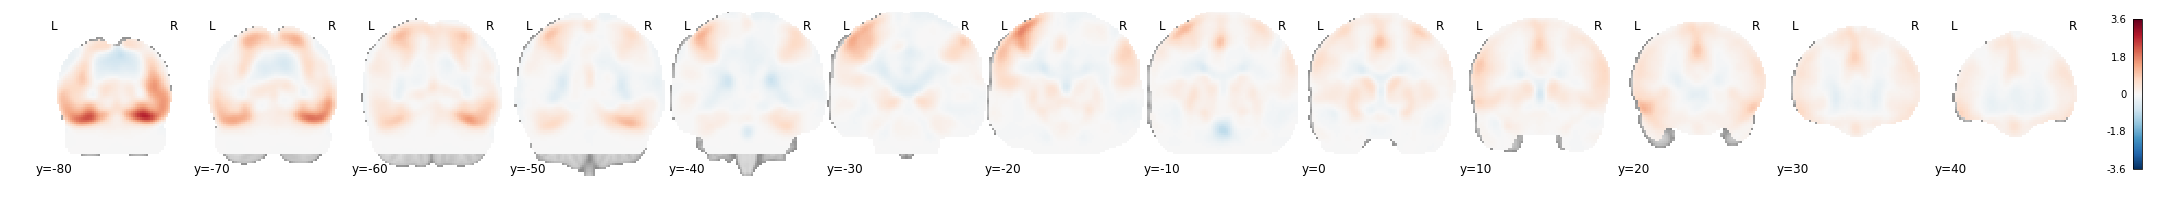

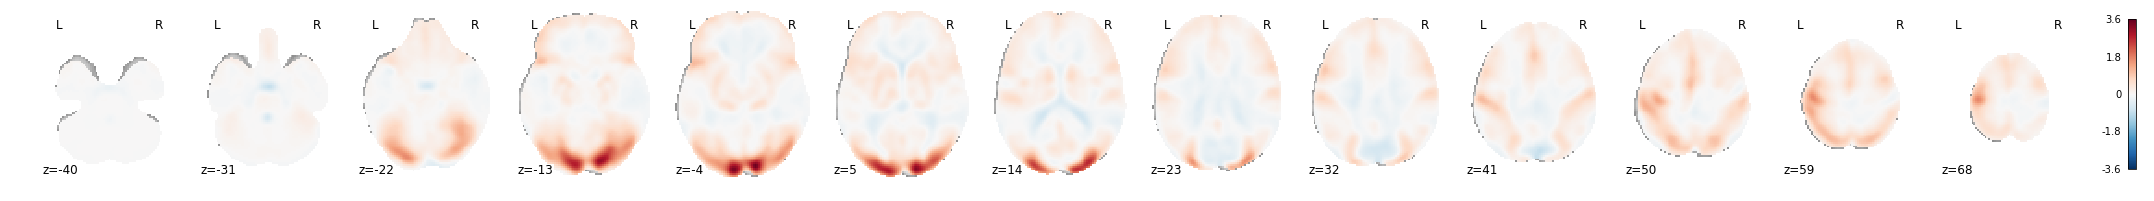

In [56]:
from nltools.plotting import plotBrain

plotBrain(data.mean())

# Multivariate Prediction
Running MVPA style analyses using multivariate regression is even easier and faster 
than univariate methods. All you need to do is specify the algorithm and 
cross-validation parameters. Currently, we have several different linear algorithms
implemented from [scikit-learn](http://scikit-learn.org/stable/).

Here is a helpful [blog post](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/) on different algorithms and reasonable default parameters.

## Prediction with Cross-Validation
Cross-validation is critical for evaluating the performance of models.  We recommend splitting the data into a training and separate holdout test sets.  The final holdout set should only be used to test the model once, while the training data can be explored and fit multiple times (though we do recommend cross-validation here too).  As an example, we will split the data into train (2/3 of data) and test (1/3 of data) based on a stratifed sampling approach.  See details [here](http://cosanlab.com/static/papers/Changetal2015PLoSBiology.pdf).

In [2]:
# Apologies. Boolean indexing broke with new version of pandas.  Usually way easier to do this.
train = data.empty()
train.data = data.data[data.X['Holdout']=='Train']
train.X = data.X[data.X['Holdout']=='Train']
train.Y = data.X['Rating'][data.X['Holdout']=='Train']
test = data.empty()
test.data = data.data[data.X['Holdout']=='Test']
test.X = data.X[data.X['Holdout']=='Test']
test.Y = data.X['Rating'][data.X['Holdout']=='Test']

We can now predict the output variable is a dictionary of the most 
useful output from the prediction analyses. The predict function runs 
the prediction multiple times. One of the iterations uses all of the 
data to calculate the `weight_map`. The other iterations are to estimate 
the cross-validated predictive accuracy.  For speed, we are only going to estimate the model using all of the data.  See examples below for different algorithms and cross-validation schemes.

In [63]:
stats = train.predict(algorithm='ridge',plot=False)

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00


Display the available data in the output dictionary

In [44]:
stats.keys()

['weight_map', 'rmse_all', 'r_all', 'intercept', 'yfit_all', 'Y']

Plot the multivariate weight map

Plotting unthresholded image


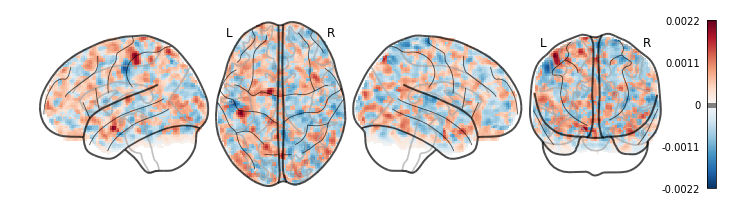

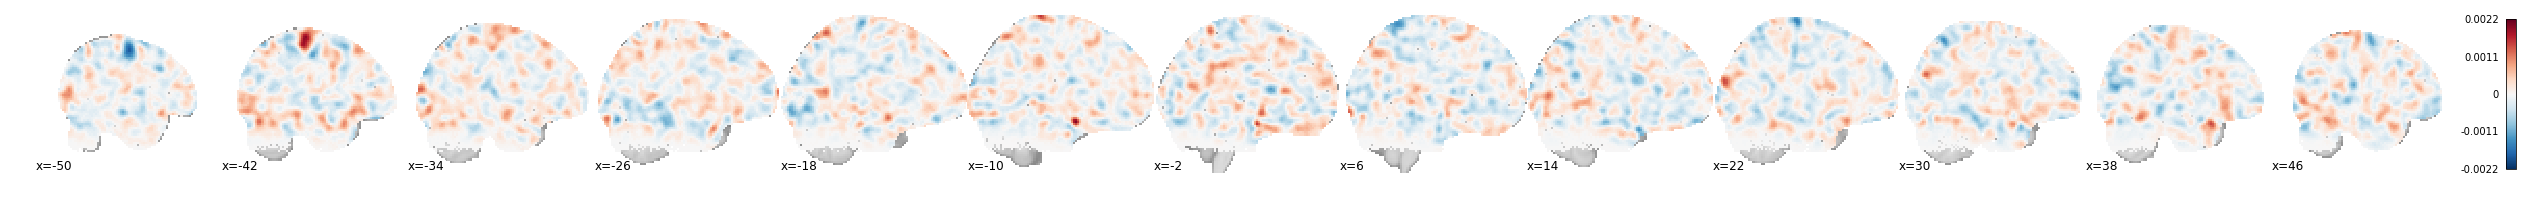

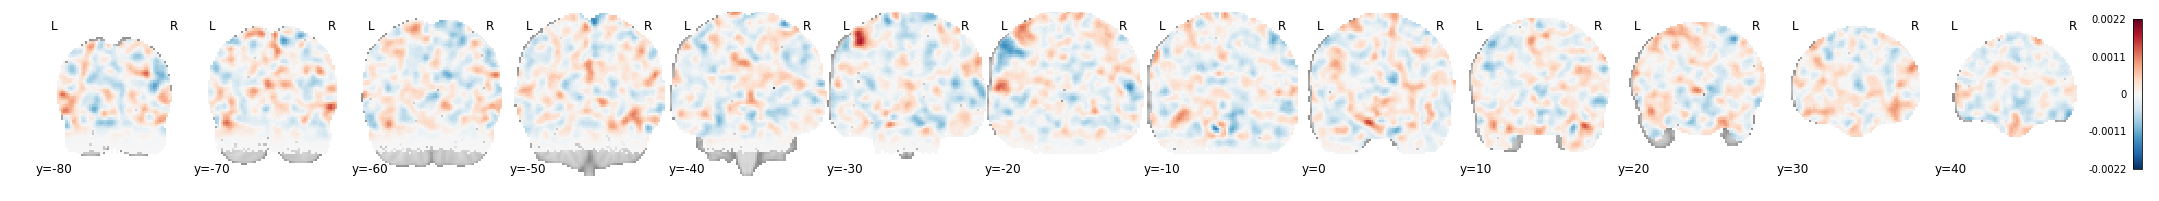

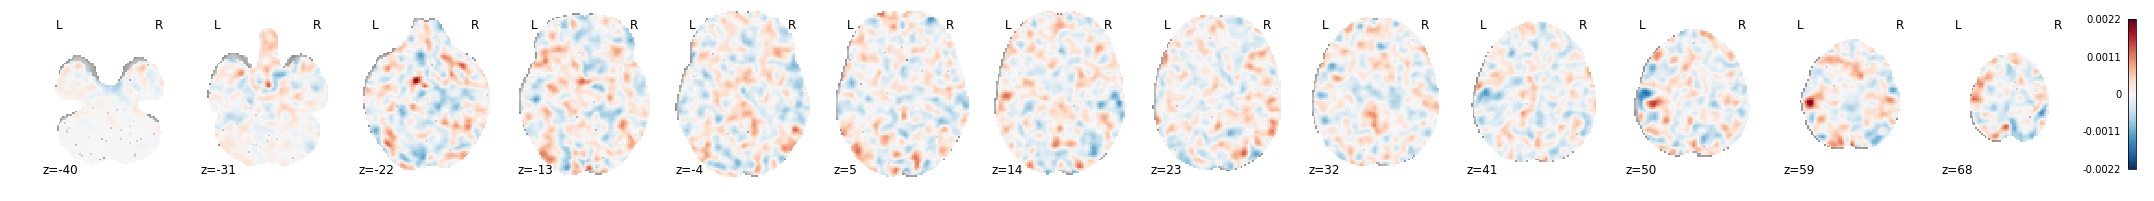

In [64]:
plotBrain(stats['weight_map'])

## Generalizability - Test model on holdout data
Once we have a model that we are happy with and performs the best in cross-validation on the training data, we can test it on the holdout test dataset.  It is important to mention that this should only happen once and should be the final results reported in the paper.  The reason is because it is easy to introduce bias and trick yourself into thinking that the model will generalize better than it should.

This two level cross-validation scheme provides a way to explore and try lots of different algorithms and feature selection methods, without overfitting the data.

Because this is a regression we also need to remember to add the intercept to shift the predicted values.

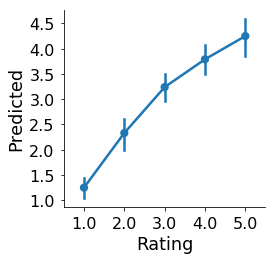

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

predicted_emotion = test.similarity(stats['weight_map'],'dot_product') + stats['intercept']

dat = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_emotion,'Rating':test.X['Rating']})
with sns.plotting_context(context='paper',font_scale=2):
    sns.factorplot(data=dat,x='Rating',y='Predicted')

We can also do similarity instead of dot product to compare performance of model across data on different scales

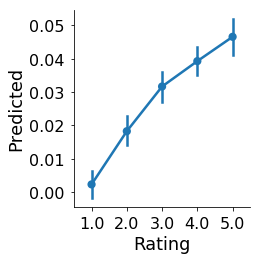

In [66]:
predicted_emotion = test.similarity(stats['weight_map'],'correlation')

dat = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_emotion,'Rating':test.X['Rating']})
with sns.plotting_context(context='paper',font_scale=2):
    sns.factorplot(data=dat,x='Rating',y='Predicted')

# Assessing Specificity
Now that we have evaluated the sensitivity of the model in capturing affect in the holdout data, we might want to know how specific it is.  If it is simply reflecting negative arousal or salience (whatever that is) than it should be confused by other negative arousing stimuli such as thermal pain.

Here we first download a pain data set to assess the specificity from our [paper](http://cosanlab.com/static/papers/Changetal2015PLoSBiology.pdf).

In [60]:
from nltools.datasets import fetch_pain

pain = fetch_pain()
pain.Y = pain.X['PainLevel']
subject_id = pain.X['SubjectID']

Now let's test how well the PINES generalizes to the pain test data.

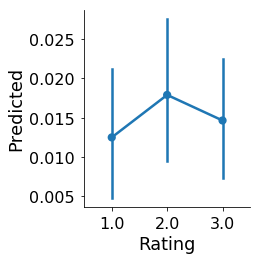

In [67]:
predicted_pain = pain.similarity(stats['weight_map'],'correlation')

pain_dat = pd.DataFrame(data={'SubjectID':pain.X['SubjectID'],'Predicted':predicted_pain,'Rating':pain.X['PainLevel']})
with sns.plotting_context(context='paper',font_scale=2):
    sns.factorplot(data=pain_dat,x='Rating',y='Predicted')

Let's put the two datasets on the same plot to show the sensitivity and specificity (at least with respect to pain)

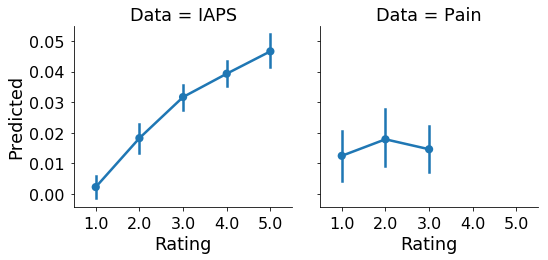

In [68]:
dat['Data']='IAPS'
pain_dat['Data']='Pain'
d = pd.concat([dat,pain_dat])
with sns.plotting_context(context='paper',font_scale=2):
    sns.factorplot(data=d,x='Rating',y='Predicted',col='Data')

# Feature Selection
Feature selection describes the process of deciding which features to include when training the model.  Here it is simply, which voxels should we use to train the model?

There are several ways to perform feature selection.  Searchlights are a popular approach.  I personally have a preference for using parcellation schemes.
 - Parcellations are orders of magnitude computationally less expensive than searchlights.
 - Parcellations are easier to correct for multiple comparisons (50 vs 300k)
 - Parcellations can include regions distributed throughout the brain (searchlights are only local)
 - Parcellations can be integrated into a meta-model.
 
Here we download a single 50 parcel map from a forthcoming paper on conducting automated parcellations using neurosynth.

    Yarkoni, T., de la Vega, A., & Chang, L.J. (In Prep).  Fully automated meta-analytic clustering and decoding of human brain activity

Some of the details can be found [here](http://cosanlab.com/static/papers/delaVega_2016_JNeuro.pdf)

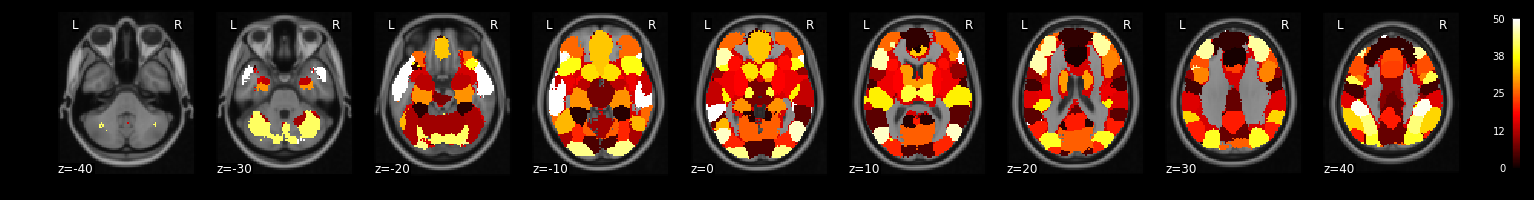

In [50]:
from nltools.mask import expand_mask, collapse_mask
from nltools.data import Brain_Data

mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask.plot()

We can easily expand the mask into separate binary masks, which makes it easier to use.

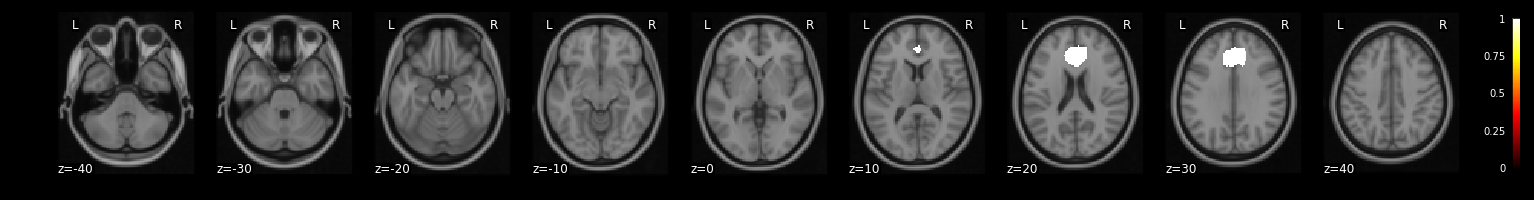

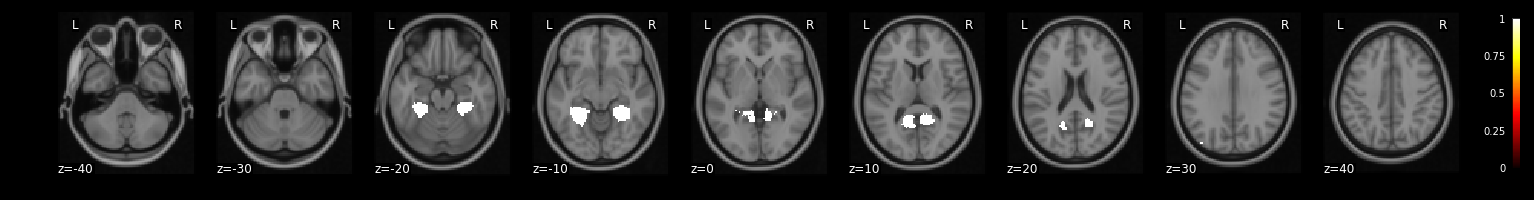

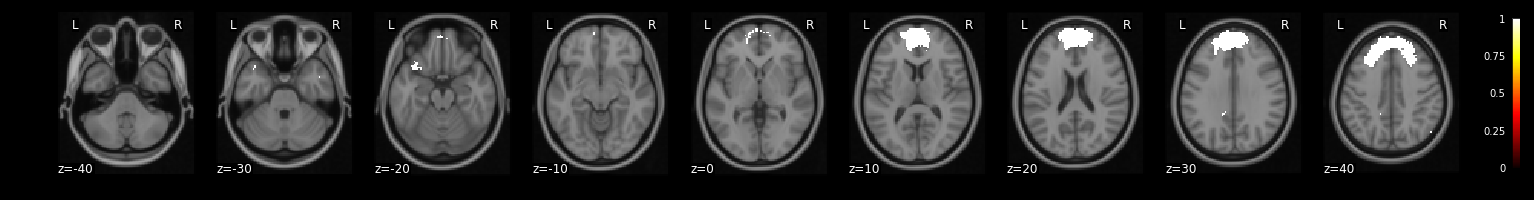

In [52]:
mask_x = expand_mask(mask)
mask_x.plot(limit=3)

First, let's see how well we can predict pain intensity using whole brain

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 0.90
overall CV Correlation: 0.58


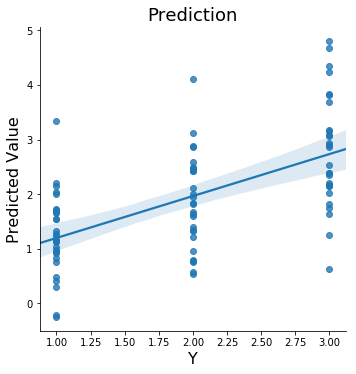

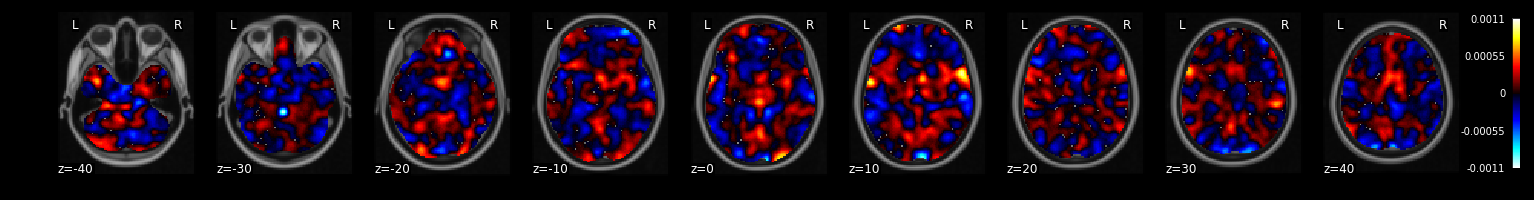

In [53]:
stats = pain.predict(algorithm='ridge', cv_dict={'type': 'kfolds','n_folds': 5,'subject_id':subject_id})

Now let's see how well we can do with a subset of the voxels by only training voxels located in the ACC

You can see we are doing pretty good with only the ACC, but the whole brain is capturing more variance.  This implies that information is distributed more broadly than just the ACC.

See [Lieberman & Eisenberger (2016)](http://www.pnas.org/content/112/49/15250.abstract) and  our rebuttal [Wager et al (2016)](http://cosanlab.com/static/papers/Wager_2016_PNAS.pdf) along with [Tal Yarkoni's](https://www.talyarkoni.org/blog/2015/12/05/no-the-dorsal-anterior-cingulate-is-not-selective-for-pain-comment-on-lieberman-and-eisenberger-2015/), [Tor Wager](http://www.painresearchforum.org/news/blog/61907-pain-acc), and [Alex Shackman's](http://shackmanlab.org/the-importance-of-respecting-variation-in-cingulate-anatomy-comment-on-lieberman-eisenberger-2015-and-yarkoni/) Blogpost and for a more detailed debate about the selectivity of the dACC in processing pain.

overall Root Mean Squared Error: 0.36
overall Correlation: 0.90
overall CV Root Mean Squared Error: 1.15
overall CV Correlation: 0.41


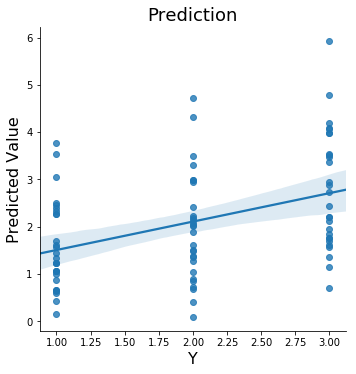

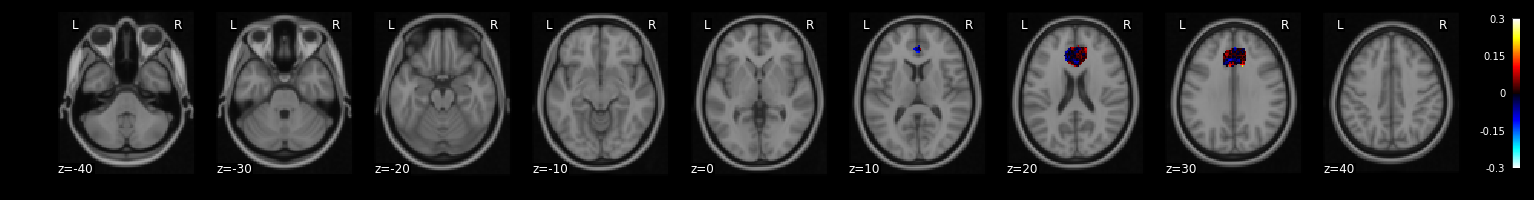

In [54]:
masked_stats = pain.apply_mask(mask_x[0]).predict(algorithm='ridge', cv_dict={'type': 'kfolds','n_folds': 5,'subject_id':subject_id})

## Algorithms
There are several types of linear algorithms implemented including:
Support Vector Machines (svr), Principal Components Analysis (pcr), and 
penalized methods such as ridge and lasso.  These examples use 5-fold
cross-validation holding out the same subject in each fold.

In [28]:
subject_id = train.X['SubjectID']
svr_stats = train.predict(algorithm='svr', 
                        cv_dict={'type': 'kfolds','n_folds': 5,
                        'subject_id':subject_id}, **{'kernel':"linear"})

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Lasso Regression

In [ ]:
lasso_stats = train.predict(algorithm='lasso', 
                        cv_dict={'type': 'kfolds','n_folds': 5,
                        'subject_id':subject_id}, **{'alpha':.1})

Principal Components Regression

In [ ]:
pcr_stats = train.predict(algorithm='pcr', 
                        cv_dict={'type': 'kfolds','n_folds': 5,
                        'subject_id':subject_id})

## Cross-Validation Schemes
There are several different ways to perform cross-validation.  The standard 
approach is to use k-folds, where the data is equally divided into k subsets
and each fold serves as both training and test.  
Often we want to hold out the same subjects in each fold. This can be done by passing in a vector of unique subject IDs that 
correspond to the images in the data frame.

In [ ]:
subject_id = data.X['SubjectID']
ridge_stats = data.predict(algorithm='ridge', 
                        cv_dict={'type': 'kfolds','n_folds': 5,'subject_id':subject_id}, 
                        plot=False, **{'alpha':.1})

Sometimes we want to ensure that the training labels are balanced across 
folds.  This can be done using the stratified k-folds method.  

In [ ]:
ridge_stats = data.predict(algorithm='ridge', 
                        cv_dict={'type': 'kfolds','n_folds': 5, 'stratified':data.Y}, 
                        plot=False, **{'alpha':.1})

Leave One Subject Out Cross-Validaiton (LOSO) is when k=n subjects.  
This can be performed by passing in a vector indicating subject id's of 
each image and using the loso flag.

In [ ]:
ridge_stats = data.predict(algorithm='ridge', 
                        cv_dict={'type': 'loso','subject_id': subject_id}, 
                        plot=False, **{'alpha':.1})

There are also methods to estimate the shrinkage parameter for the 
penalized methods using nested crossvalidation with the 
ridgeCV and lassoCV algorithms.

In [ ]:
import numpy as np

ridgecv_stats = data.predict(algorithm='ridgeCV', 
                        cv_dict={'type': 'kfolds','n_folds': 5, 'stratified':data.Y}, 
                        plot=False, **{'alphas':np.linspace(.1, 10, 5)})